# 분류기(Classifier) 학습하기

지금까지 어떻게 신경망을 정의하고, 손실을 계산하며 또 가중치를 갱신하는지에 대해서 배웠습니다.

이제 아마도 이런 생각을 하고 계실텐데요.

## 데이터는 어떻게 하나요?

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰텐데요, 이러한 데이터는 표준 Python 패키지를 사용하여 불러온 후 NumPy 배열로 변환하면 됩니다. 그리고 그 배열을 torch.*Tensor 로 변환하면 됩니다.

- 이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
- 오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
- 텍스트의 경우에는 그냥 Python이나 Cython의 것들을 사용하거나, NLTK나 SpaCy도 좋습니다.

특별히 영상 분야를 위해서는 torchvision 이라는 패키지를 만들어두었는데요, 여기에는 Imagenet이나 CIFAR10, MNIST 등과 같은 일반적으로 사용하는 데이터셋을 불러오는 함수들(data loaders)이나, image, viz., torchvision.datasets 와 torch.utils.data.DataLoader 데이터 변환기가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서 작성하는 것을 피할 수 있습니다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용할 텐데요, 여기에는 다음과 같은 분류들이 있습니다: ‘비행기(airplane)’, ‘자동차(automobile)’, ‘새(bird)’, ‘고양이(cat)’, ‘사슴(deer)’, ‘개(dog)’, ‘개구리(frog)’, ‘말(horse)’, ‘배(ship)’, ‘트럭(truck)’. 그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32인데요, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)로 이뤄져 있다는 뜻입니다.

## 이미지 분류기 학습하기

다음의 단계로 진행해보겠습니다:

1. CIFAR10의 학습용 / 시험(test)용 데이터셋을 torchvision 을 사용하여 불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

### 1. CIFAR10를 불러오고 정규화하기

torchvision 을 사용하면 매우 쉽게 CIFAR10 데이터를 불러올 수 있습니다.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다. 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환하겠습니다.

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


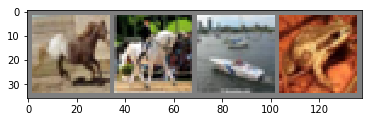

plane   dog   car truck


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.show()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 합성곱 신경망(Convolution Neural Network) 정의하기

이전에 배웠던 신경망 섹션에서 신경망을 복사하고, (기존에 1채널 이미지만 처리하던 것 대신) 3채널 이미지를 처리할 수 있도록 수정합니다.

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input channel 3
        self.conv1 = nn.Conv2d(3, 6, 5) # input channel, output channel, filter size
        self.pool = nn.MaxPool2d(2, 2) # Max pool -> Down sampling
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. 손실 함수와 Optimizer 정의하기

이제, 분류에 대한 교차 엔트로피 손실(Cross-Entropy loss)과 momentum을 갖는 SGD를 사용합니다.

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 신경망 학습하기

이제부터 흥미로우실 겁니다. 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면 됩니다.

In [21]:
for epoch in range(2):  # 데이터셋을 수차례 반복합니다. (epoch 2번)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 입력을 받은 후
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs) # 네트워크 통과 후 output 연산
        loss = criterion(outputs, labels) # loss 연산 (label이 실제 답(y), output은 결과(y_hat))
        loss.backward() # 역전파
        optimizer.step() # 최적화 -> 가중치 update(SGD)

        # 통계 출력
        running_loss += loss.item()
        # print(running_loss)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.909
[1,  4000] loss: 0.898
[1,  6000] loss: 0.903
[1,  8000] loss: 0.930
[1, 10000] loss: 0.928
[1, 12000] loss: 0.949
[2,  2000] loss: 0.835
[2,  4000] loss: 0.864
[2,  6000] loss: 0.903
[2,  8000] loss: 0.886
[2, 10000] loss: 0.881
[2, 12000] loss: 0.903
Finished Training


### 5. 시험용 데이터로 신경망 검사하기

학습용 데이터셋을 2회 반복하여 신경망을 학습시켰는데요, 신경망이 전혀 배운게 없을지도 모르니 확인해보겠습니다.

신경망이 예측한 정답과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인할텐데요, 예측이 맞다면 샘플을 ‘맞은 예측값(Correct predictions)’에 넣겠습니다.

먼저 시험용 데이터를 좀 보겠습니다.

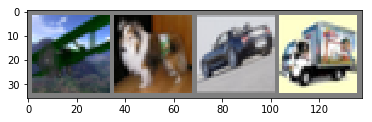

GroundTruth:    cat  ship  ship plane


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

좋습니다, 이제 신경망이 어떻게 예측했는지를 보죠:

In [14]:
outputs = net(images)
print(images) # 4개의 이미지
print(outputs) # 결과물

tensor([[[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
          [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
          [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
          ...,
          [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
          [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
          [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],

         [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
          [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
          [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
          ...,
          [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
          [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
          [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],

         [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
          [-0.6000, -0.6863, -

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이 나타난다는 것은, 신경망이 그 이미지가 더 해당 분류에 가깝다고 생각한다는 것입니다. 따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:

In [15]:
_, predicted = torch.max(outputs, 1)

print(_)
print(predicted)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

tensor([0.0681, 0.0670, 0.0617, 0.0708], grad_fn=<MaxBackward0>)
tensor([1, 0, 5, 0])
Predicted:    car plane   dog plane


그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.

In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


(10가지 분류에서 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다. 신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:

In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 81 %
Accuracy of  bird : 48 %
Accuracy of   cat : 41 %
Accuracy of  deer : 59 %
Accuracy of   dog : 49 %
Accuracy of  frog : 73 %
Accuracy of horse : 68 %
Accuracy of  ship : 75 %
Accuracy of truck : 71 %
